In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [3]:
# Load the training data
train_full_df = pd.read_csv('../data/train.csv').drop('Id', axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Create an EdaToolbox object

In [4]:
# Initialize the EdaToolbox
target_col = 'SalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

## First check the distribution of the target column and select an appropriate target column transformer

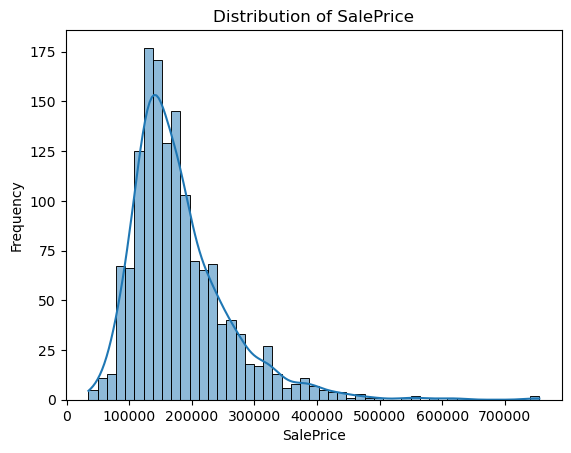

In [5]:
# Plot target column distribution
eda.plot_regression_target_column_distribution()

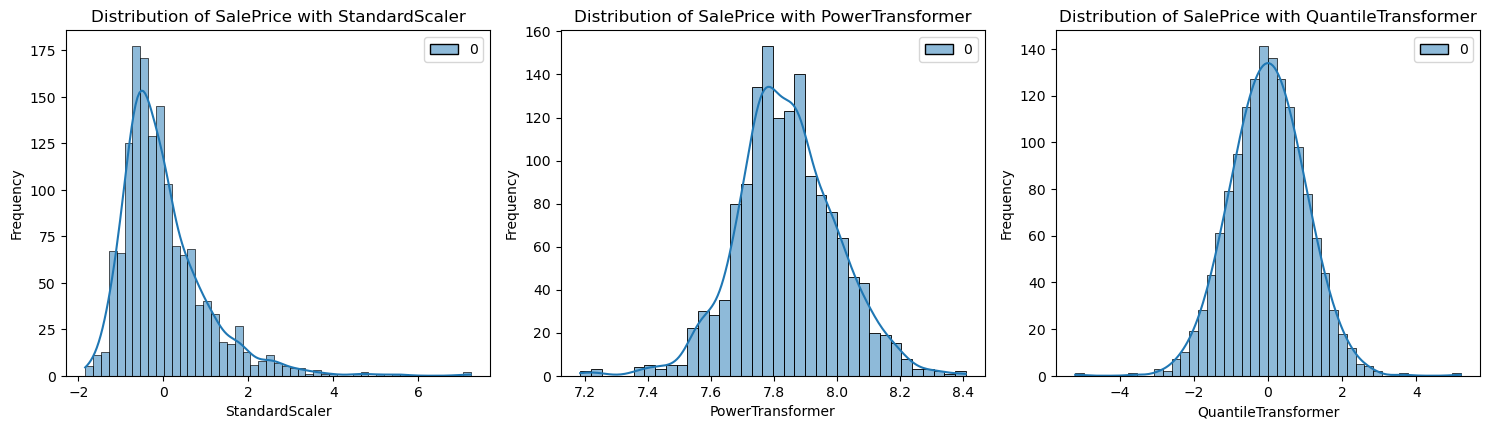

In [6]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}
eda.plot_regression_target_column_distribution_variations(target_transformation_dict)

# NOTE: The PowerTransformer evenly distributes the data but not around Zero which is good for this dataset
#       because there are no negative SalePrice values.

In [7]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV()
}


In [8]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV
StandardScaler,0.425360,0.425237,1.103302,0.922071,0.438173,0.437097,0.423935
PowerTransformer,0.055131,0.055102,0.171965,0.171965,0.054301,0.054316,0.054885
QuantileTransformer,0.336151,0.335978,1.102105,0.881407,0.332025,0.333955,0.334855


## Set the target and feature column tranformers

In [9]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [10]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
Utilities,object,0.999315,AllPub,2,0,0.0,"Index(['AllPub', 'NoSeWa'], dtype='object', na..."
Street,object,0.995890,Pave,2,0,0.0,"Index(['Pave', 'Grvl'], dtype='object', name='..."
Condition2,object,0.989726,Norm,8,0,0.0,"Index(['Norm', 'Feedr', 'Artery', 'RRNn', 'Pos..."
RoofMatl,object,0.982192,CompShg,8,0,0.0,"Index(['CompShg', 'Tar&Grv', 'WdShngl', 'WdSha..."
Heating,object,0.978082,GasA,6,0,0.0,"Index(['GasA', 'GasW', 'Grav', 'Wall', 'OthW',..."


In [11]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [12]:
# Frist do basic scaling and encoding to see what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.90)


c:\Users\jim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__GrLivArea,0.697017,0.018441,0.105747,inf,0.159296,0.320902,1.195657
numerical__OverallQual,0.815044,0.026660,0.191351,4.225290,0.219882,0.038297,1.099882
ordinal_neighborhood__Neighborhood,0.740302,0.023124,0.169299,3.429729,0.208808,0.023143,0.995377
numerical__YearBuilt,0.588037,0.004407,0.967901,8.363907,0.210607,0.188031,0.991081
numerical__TotRmsAbvGrd,0.532020,0.009357,0.524814,5.298685,0.115297,0.311225,0.967899


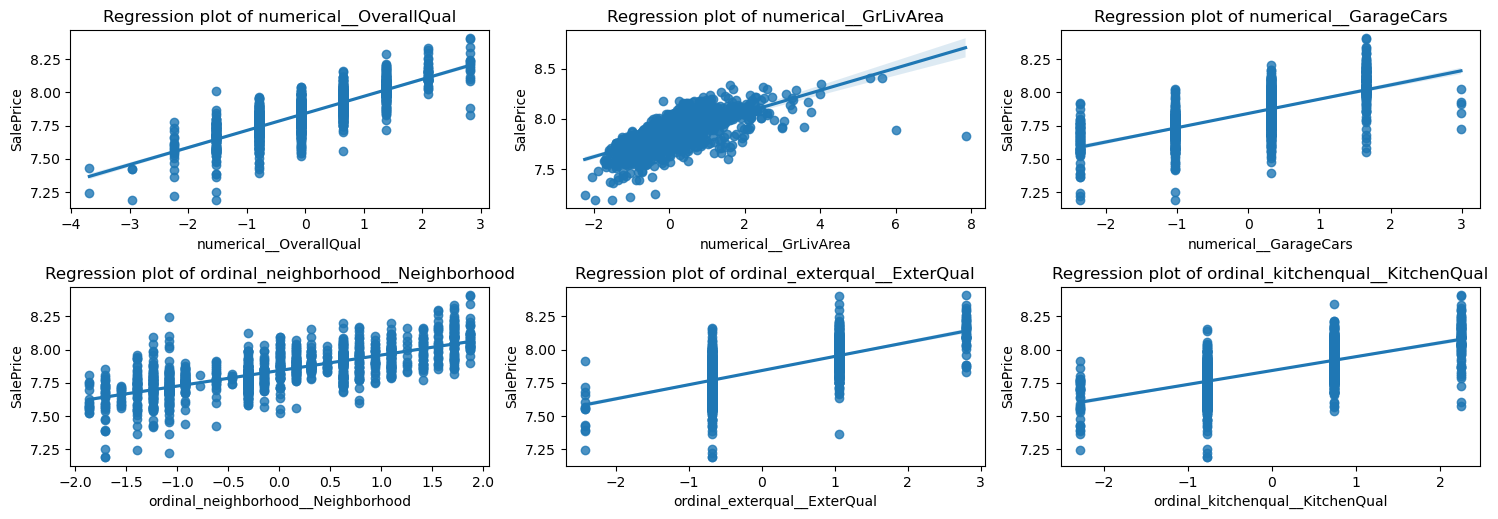

In [13]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.65)

## Perform unsupervised feature selection

Optimal number of features: 19


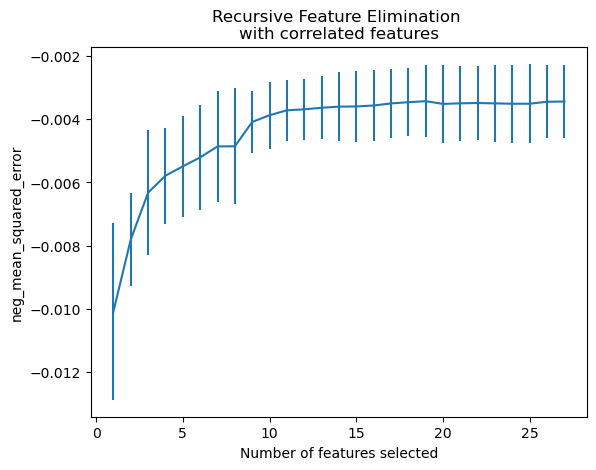

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-0.010078,0.002805,-0.007919,-0.010006,-0.008646,-0.015509,-0.008309,True,1,MSSubClass
1,-0.007803,0.001466,-0.005844,-0.007427,-0.007505,-0.010388,-0.007853,False,31,LotFrontage
2,-0.006321,0.001976,-0.004893,-0.005446,-0.005192,-0.010222,-0.005852,False,37,LotArea
3,-0.005787,0.001516,-0.003811,-0.005311,-0.004957,-0.008232,-0.006622,True,1,OverallQual
4,-0.005493,0.001589,-0.003685,-0.004679,-0.004464,-0.008018,-0.006620,True,1,OverallCond


In [30]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [17]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

Selected LR features: ['MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'BsmtFinSF1'
 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' 'GrLivArea' 'BsmtFullBath'
 'TotRmsAbvGrd' 'GarageCars' 'MSZoning' 'Neighborhood' 'BsmtQual'
 'CentralAir' 'KitchenQual' 'FireplaceQu' 'SaleCondition']


In [29]:
# Check Square footage features to see what can be dropped
# GrLivArea = 1stFlrSF + 2ndFlrSF
sf_features_list = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
sf_df = eda.df[sf_features_list]
sf_df

,GrLivArea,1stFlrSF,2ndFlrSF,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
0,1710,856,854,856,706,0,150
1,1262,1262,0,1262,978,0,284
2,1786,920,866,920,486,0,434
3,1717,961,756,756,216,0,540
4,2198,1145,1053,1145,655,0,490
...,...,...,...,...,...,...,...
1455,1647,953,694,953,0,0,953
1456,2073,2073,0,1542,790,163,589
1457,2340,1188,1152,1152,275,0,877
1458,1078,1078,0,1078,49,1029,0


In [34]:
# Remove features with high VIF
rfe_lr_selected_features = list(rfe_lr_selected_features)
rfe_lr_selected_features.remove('TotalBsmtSF')
# Add features that seem relevent to the model
rfe_lr_selected_features.append('FullBath')
rfe_lr_selected_features.append('HalfBath')
rfe_lr_selected_features

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'GrLivArea',
 'BsmtFullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'MSZoning',
 'Neighborhood',
 'BsmtQual',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'SaleCondition',
 'FullBath',
 'HalfBath']

Optimal number of features: 36


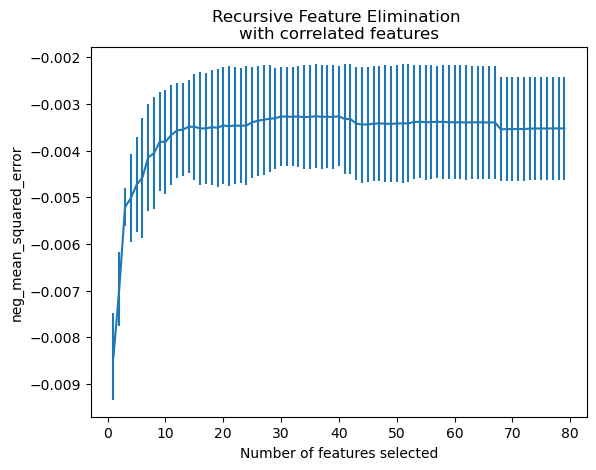

In [31]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [26]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'BsmtFinSF1' '1stFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'GarageCars' 'WoodDeckSF'
 'ScreenPorch' 'MSZoning' 'Street' 'LandContour' 'LotConfig'
 'Neighborhood' 'Condition1' 'BldgType' 'HouseStyle' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtExposure' 'HeatingQC' 'CentralAir'
 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageQual' 'SaleCondition']


In [27]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 15features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=20)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1000.0
Selected 20 features by forward sequential featureselection in 15.314 seconds
SFS Ridge Selected Features: ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'GarageCars', 'ScreenPorch', 'MSZoning', 'Neighborhood', 'Condition1', 'BsmtQual', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'SaleCondition']


In [35]:
# Update EDA object with selected features
eda.selected_feature_list = rfe_lr_selected_features

# Now get the list of important ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(7,
 ['MSZoning',
  'Neighborhood',
  'BsmtQual',
  'CentralAir',
  'KitchenQual',
  'FireplaceQu',
  'SaleCondition'])

## Perform final EDA with selected features and ordinal columns

In [36]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['MSSubClass',
                                                                                                     'OverallQual',
                                                                                                     'OverallCond',
                                                                                                     'YearBuilt',
                                                                                                     'BsmtFinSF1',
                                                                                                     'BsmtFinSF2',
                                                                                                     'BsmtUnfSF',
                                                                                                     'GrLivArea',
                                                                                                     'BsmtFullBath',
                                                                                                     'TotRmsAbvGrd',
                                                                                                     'GarageCars',
                                                                                                     'MSZoning...
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['FireplaceQu']),
                                ('ordinal_salecondition',
                                 Pipeline(memory='named_steps',
                                          steps=[('SaleCondition',
                                                  OrdinalEncoder(categories=[['AdjLand',
                                                                              'Abnorml',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial']],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['SaleCondition'])])

In [37]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.88)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__OverallQual,0.815044,0.031100,0.065882,3.587940,0.348989,0.034559,1.229691
numerical__GrLivArea,0.697017,0.032295,0.032544,6.252360,0.285401,0.211304,1.226018
ordinal_neighborhood__Neighborhood,0.740302,0.025566,0.071250,3.033636,0.330143,0.080859,1.176871
numerical__FullBath,0.594022,0.008325,0.939555,2.736791,0.284935,0.196551,1.083834
ordinal_bsmtqual__BsmtQual,0.645938,0.011228,0.436033,2.673101,0.303832,0.103422,1.064420


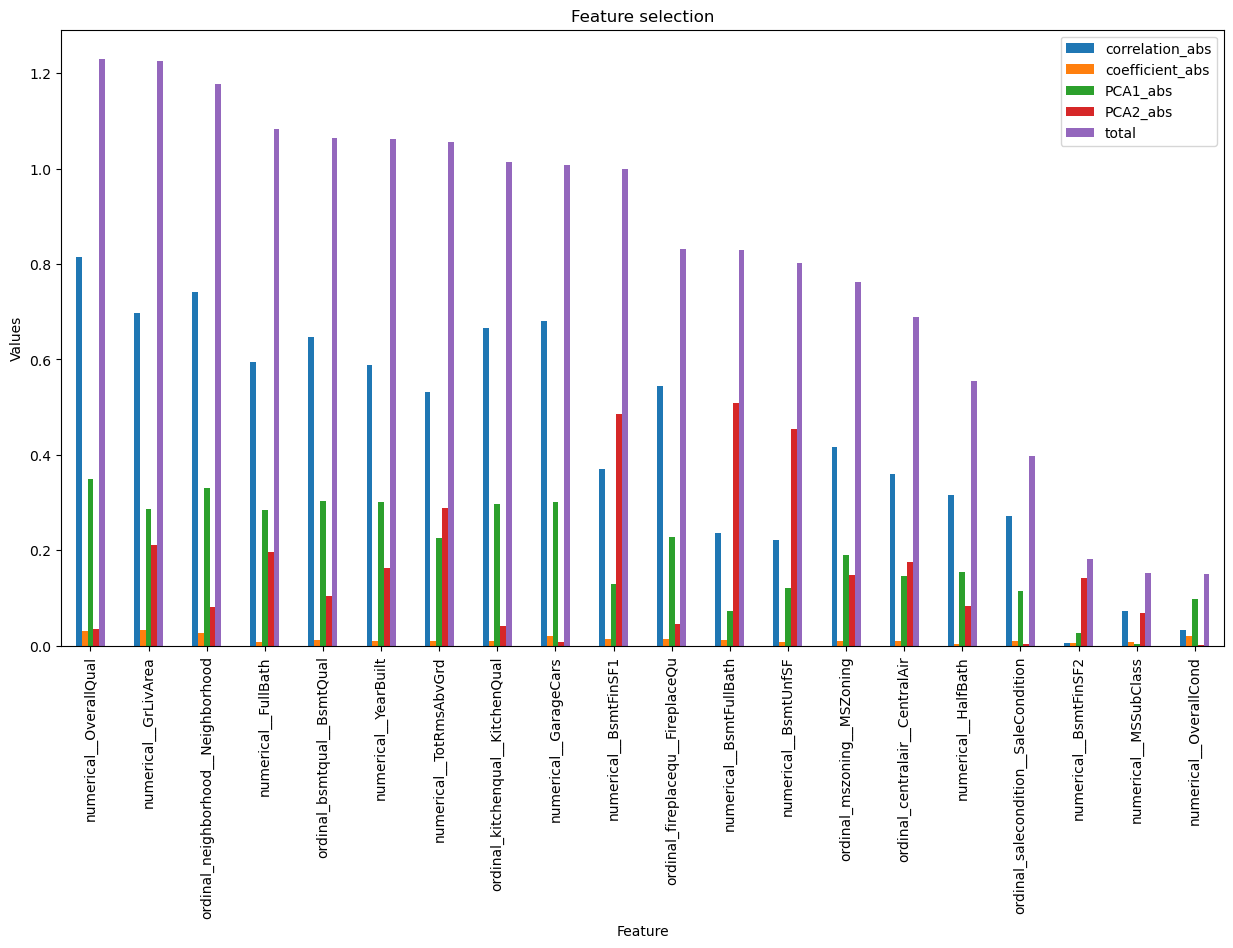

In [38]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [39]:
# Reload the data just to be safe
train_full_df = pd.read_csv('../data/train.csv')

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column='SalePrice')
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [40]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7))
}

In [41]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 80
Number scaled X cols: 20


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time
model_name,,,,,,,
Linear Regression,0.877343,0.002840,0.903373,0.896241,0.893954,0.043675,0.004584
Ridge Regression,0.877343,0.002840,0.903359,0.896226,0.893954,0.043675,0.018751
RidgeCV,0.876243,0.002924,0.900514,0.893172,0.893954,0.043675,0.012008
LassoCV,0.875611,0.003053,0.896114,0.888447,0.893954,0.043675,0.088281
ElasticNetCV,0.875597,0.003054,0.896086,0.888417,0.893954,0.043675,0.078315


In [42]:
# Get the best model
reg.best_model_name

'Linear Regression'

## Now use the best model to predict on the test data

In [43]:
# Load test data
test_full_df = pd.read_csv('../data/test.csv')
test_full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [44]:
# Make predictions
predictions = reg.predict(test_full_df)
predictions

array([117724.98674212, 147028.0238897 , 172610.76672372, ...,
       160105.70409357, 113835.74954354, 222049.15448674])

In [45]:
# Prepare submission file
new_submission_df = pd.DataFrame({
    'Id': test_full_df['Id'],
    'SalePrice': predictions
})
new_submission_df.to_csv('../data/new_submission_4.csv', index=False)
new_submission_df

,Id,SalePrice
0,1461,117724.986742
1,1462,147028.023890
2,1463,172610.766724
3,1464,194386.116440
4,1465,189461.523664
...,...,...
1454,2915,93002.673297
1455,2916,87089.280769
1456,2917,160105.704094
1457,2918,113835.749544
